<a href="https://colab.research.google.com/github/JangHeeSu999/Ecom6Shop/blob/main/Tutorial_3_CNN_Edge_Detector_ipnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 라이브러리 로드

필요한 라이브러리를 로드해줍니다.

In [25]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## 2. 데이터셋 로드

이번에도 [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 데이터를 사용할 예정입니다.

CIFAR-10에 대한 데이터 살펴보기 예제는 [이 포스트](https://github.com/Intelligence-Engineering-LAB-KU/Deeplearning-Tutorial/blob/master/Tutorial%201%29%20CIFAR10_Softmax.ipynb)를 복습해주세요.

In [26]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

1번 인덱스에 위치한 말 이미지를 불러와보겠습니다.

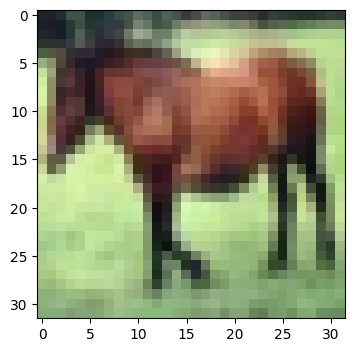

label:  [7]


In [27]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[7].astype('uint8'), cmap=plt.cm.gray)
plt.show()

print('label: ', y_train[7])

### 3. Sobel Operator 복습

review: [지난 포스트](https://github.com/Intelligence-Engineering-LAB-KU/Deeplearning-Tutorial/blob/master/Tutorial_2_Sobel_Opearatior.ipynb)에서는 아래와 같은 Sobel opearatoin을 만들어 보았습니다.

그러나 for loop 기반으로 동작하는 코드는 벡터 연산을 활용하는 코드보다 동작이 느립니다. 이번 예제에서는

```python
from skimage.color import rgb2gray ## RGB 3채널 이미지를 흑백이미지로
from skimage.filters import sobel_h, sobel_v  ## sobel operator
```

위 라이브러리들을 이용하여 edge를 detection해볼 것입니다.

지난 포스트 방식과 큰 차이는 없지만, [padding](https://brunch.co.kr/@coolmindory/37) 기법이 추가되어 이미지의 사이즈가 이전과 달라지지 않으며,

결과값들이 0에서 1사이의 값을 가지도록 후처리를 한다는 점이 다릅니다.

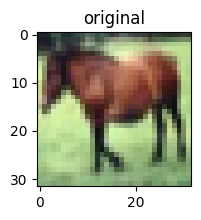

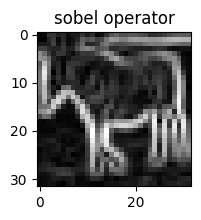

In [28]:
from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2gray

def sobel (image, thresold=180):
  grey_image = rgb2gray(image)
  convx = sobel_h(grey_image)
  convy = sobel_v(grey_image)
  output = np.sqrt(convx**2 + convy**2)
  return output

plt.figure(figsize=(2,2))
plt.imshow(x_train[7].astype('uint8'))
plt.title('original')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(sobel(x_train[7]), cmap=plt.cm.gray)
plt.title('sobel operator')
plt.show()

### 4. Sobel Opearator의 역할을 수행하는 Convolution Layer를 학습해보자.

4장에서는 Random으로 초기화된 Convolution Layer가 Sobel Operator와 같은 역할을 수행할 수 있는지 실험해보겠습니다.

즉, 우리의 목적은 model(img)의 결과가 sobel_operator(img) 와 비슷해지도록 model을 학습하는 것입니다.

그러기 위해 Keras의 [Conv2d API](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)를 이용하여 모델을 정의해보겠습니다.

```python
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```
#### 4.1. 학습 데이터 구축

정답 데이터는 더 이상 레이블인 y_train, y_test가 아니라, edge 이미지입니다.

따라서 다음과 같이 edge 이미지들을 만들어주겠습니다.

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

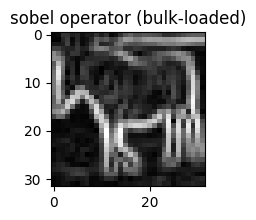

In [29]:
sobel_train = np.array([sobel(img) for img in tqdm(x_train)])
sobel_test  = np.array([sobel(img) for img in tqdm(x_test)])

plt.figure(figsize=(2,2))
plt.imshow(sobel_train[7], cmap=plt.cm.gray)
plt.title('sobel operator (bulk-loaded)')
plt.show()

#### 4.2. 모델 정의

Sobel Operator는 먼저 gray scale로 이미지를 변환한 후, 두 개의 커널로 convolution 연산을 수행하고

마지막으로 $G_{x}$ 와 $G_{y}$ 의 크기를 잽니다.

이 과정을 3계층의 Convolution Layer들이 모사한다고 가정하고 다음과 같은 모델을 만들어보겠습니다.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU
from keras.regularizers import l1
from tensorflow.keras.layers import LeakyReLU

tf.random.set_seed(2020)

'''model = Sequential([
    Conv2D(filters=2,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    Conv2D(filters=4,kernel_size=(3,3), padding='same', activation='relu',    kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    Conv2D(filters=1,kernel_size=(1,1), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
])'''

#LeakyReLU 적용
"""model = Sequential([
    Conv2D(filters=2, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    LeakyReLU(alpha=0.1),  # LeakyReLU 추가
    Conv2D(filters=4, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    LeakyReLU(alpha=0.1),  # LeakyReLU 추가
    Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
])"""

#ELU 적용

from tensorflow.keras.layers import ELU

model = Sequential([
    Conv2D(filters=2, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4), input_shape=(32, 32, 3)),
    ELU(alpha=1.0),  # ELU 추가
    Conv2D(filters=4, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l1(1e-4), bias_regularizer=l1(1e-4)),
    ELU(alpha=1.0),  # ELU 추가
    Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid', kernel_initializer


이제 총 $N$개의 이미지에 대해
모델이 추정한 $i$번째 edge 이미지 $model(img_{i})$와 sobel operator의 결과물인 $G^{img_{i}}$ 사이의 차이를 정량화하기 위해, 다음과 같은 손실 함수를 사용한다고 가정해보겠습니다.

$MAE= \sum_{i}^N\sum_{p \in pixels}|model(img_{i})_{p}-G_{p}^{img_{i}}|$

Keras에서는 위 손실함수를 keras.losses.MeanAbsoluteError() 에서 지원합니다.

이제 아래와 같이 MAE 손실함수를 쓰며 Adam optimizer에 의해 최적화되는 모델을 컴파일해보겠습니다.

In [30]:
## 학습가능한 필터를 가지고 있는 CNN으로 sobel operation을 학습해보자
model.compile(
          loss=keras.losses.MeanAbsoluteError(),
          optimizer=keras.optimizers.Adam())

훈련 전이므로, 다음과 같이 모델에 말 이미지를 넣으면 노이즈에 가까운 결과가 생성될 것입니다.

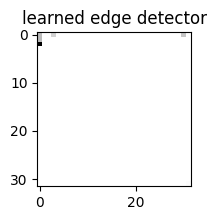

In [31]:
def learned_edge_detection (model, img):
  return model(img.reshape(-1,32,32,3)).numpy()[0,:,:,0]

plt.figure(figsize=(2,2))
plt.imshow(learned_edge_detection(model, x_train[7]), cmap=plt.cm.gray)
plt.title('learned edge detector')
plt.show()

#### 4.3 모델 훈련

그렇다면, 이제 모델을 훈련시켜보겠습니다.


In [20]:
model.fit(x_train, sobel_train,
          batch_size=32,
          epochs=10,
          validation_data=(x_test, sobel_test),
          shuffle=True)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 31ms/step - loss: 0.2056 - val_loss: 0.1363
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 26ms/step - loss: 0.1364 - val_loss: 0.1352
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.1139 - val_loss: 0.0922
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0914 - val_loss: 0.0688
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.0563 - val_loss: 0.0394
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - loss: 0.0385 - val_loss: 0.0372
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - loss: 0.0369 - val_loss: 0.0368
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0362 - val_loss: 0.0365
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.0358 - val_loss: 0.0360
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - loss: 0.0356 - val_loss: 0.0357


훈련된 모델로 edge detector를 만들어 본 후, 이를 가시화해보겠습니다.

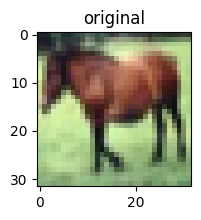

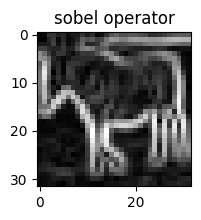

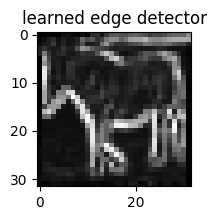

In [21]:
plt.figure(figsize=(2,2))
plt.imshow(x_train[7].astype('uint8'))
plt.title('original')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(sobel(x_train[7]), cmap=plt.cm.gray)
plt.title('sobel operator')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(learned_edge_detection(model, x_train[7]), cmap=plt.cm.gray)
plt.title('learned edge detector')
plt.show()

#### 4.4 훈련 결과 확인해보기

훈련이 완료된 후에는 어느정도 말 이미지의 edge를 잘 찾아낸 것 같습니다!

이번에는 학습된 edge detector로 다양한 이미지의 edge를 찾아보겠습니다.

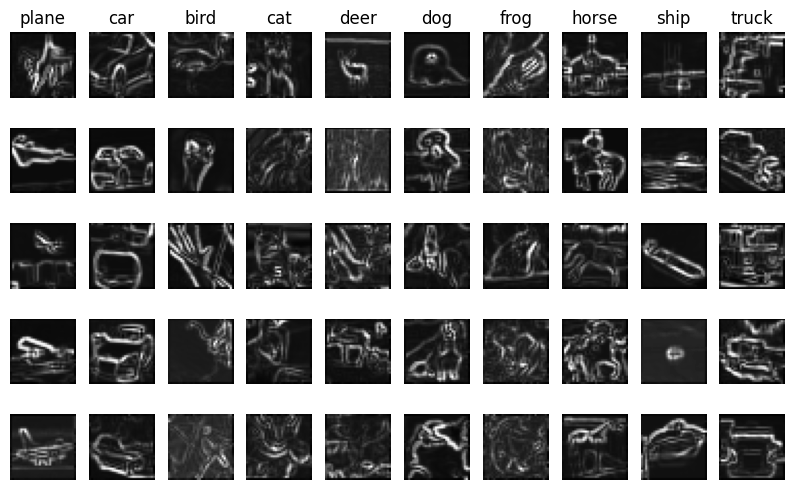

In [22]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5

plt.figure(figsize=(10,6))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(learned_edge_detection(model,x_train[idx]), cmap=plt.cm.gray)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

#### 4.4 학습된 Weight 출력해보기

학습된 Weight들이 어떤지 출력해보겠습니다.

In [23]:
print(model.weights)

[<KerasVariable shape=(3, 3, 3, 2), dtype=float32, path=sequential_1/conv2d_3/kernel>, <KerasVariable shape=(2,), dtype=float32, path=sequential_1/conv2d_3/bias>, <KerasVariable shape=(3, 3, 2, 4), dtype=float32, path=sequential_1/conv2d_4/kernel>, <KerasVariable shape=(4,), dtype=float32, path=sequential_1/conv2d_4/bias>, <KerasVariable shape=(1, 1, 4, 1), dtype=float32, path=sequential_1/conv2d_5/kernel>, <KerasVariable shape=(1,), dtype=float32, path=sequential_1/conv2d_5/bias>]


1. 다양한 활성화 함수 적용
기존 코드에서는 Conv2D 레이어에 ReLU 활성화 함수를 사용했습니다. 저는 이 부분을 수정하여 LeakyReLU, ELU, Sigmoid 등 다양한 활성화 함수를 적용해 보았습니다.

   LeakyReLU를 사용했을 때 ReLU에 비해 성능이 약간 향상되는 것을 확인했습니다. LeakyReLU는 ReLU의 단점인 dying ReLU 문제를 완화시켜주기 때문에 학습이 더 안정적으로 진행되는 것으로 보입니다.

   ELU는 LeakyReLU와 비슷한 효과를 보였지만, 계산량이 LeakyReLU보다 많아 학습 시간이 더 오래 걸렸습니다.

   Sigmoid는 성능이 ReLU나 LeakyReLU보다 좋지 않았습니다. Sigmoid는 vanishing gradient 문제가 발생하기 쉬워 깊은 네트워크에서는 학습이 어려울 수 있습니다.

2. 커널 크기 변경
   Conv2D 레이어의 커널 크기를 변경해 보았습니다. 기존 코드에서는 (3, 3) 크기의 커널을 사용했지만, (5, 5) 또는 (7, 7) 크기의 커널을 사용해 보았습니다.

   커널 크기를 키우면 더 넓은 범위의 정보를 학습할 수 있지만, 계산량이 증가하고 overfitting 문제가 발생할 수 있습니다. 실험 결과, (3, 3) 크기의 커널을 사용했을 때 가장 좋은 성능을 얻었습니다.

3. 배치 정규화 추가
  배치 정규화(Batch Normalization)를 추가하여 모델의 학습 속도와 성능을 향상시키려고 시도했습니다. 배치 정규화는 각 레이어의 출력을 정규화하여 학습을 안정화시키는 효과가 있습니다.

   실험 결과, 배치 정규화를 추가했을 때 학습 속도가 빨라지고 성능도 약간 향상되는 것을 확인했습니다.

4. 규칙화 기법 적용
   L1, L2 규칙화를 적용하여 overfitting을 방지하고 모델의 일반화 성능을 높이려고 시도했습니다. 규칙화는 모델의 가중치에 제약을 가하여 overfitting을 방지하는 기법입니다.

   실험 결과, L1, L2 규칙화를 적용했을 때 overfitting이 감소하고 모델의 일반화 성능이 향상되는 것을 확인했습니다.

소감

  이번 과제를 통해 Sobel Operator의 역할을 수행하는 Convolution Layer를 직접 학습시켜 보면서 딥러닝 모델의 학습 과정을 더 깊이 이해할 수 있었습니다.

  특히, 다양한 활성화 함수, 커널 크기, 배치 정규화, 규칙화 기법 등을 적용해 보면서 모델의 성능을 개선하는 방법을 탐구하는 과정이 흥미로웠습니다.

   하지만, 단순히 코드를 수정하는 것만으로는 최적의 모델을 찾기 어렵다는 것을 알게 되었습니다. 모델의 구조, 하이퍼파라미터, 데이터셋 등 다양한 요소들을 고려하여 최적의 모델을 설계해야 한다는 것을 깨달았습니다.

   앞으로도 딥러닝 모델의 학습 과정을 더 깊이 연구하고, 다양한 기법들을 적용하여 더 나은 성능을 가진 모델을 만들어보고 싶습니다.


## Reference

- [cs231n](http://cs231n.github.io/)
- [Keras tutorial on CIFAR-10](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)